# CS7324 - Lab 1 Report
Prepared by Zech Wolf

## 1. Business Understanding

The stroke prediction dataset from Kaggle contains 5110 patients and basic information about them, and whether or not the patient has experienced a stroke. The focus of the dataset is to use the given information about the patient to predict if they have experienced a stroke. The features for each patient in the datset range from basic demographics information, such as work type and marriage status, to health information, like BMI and average glucose level.

Strokes are very serious and often fatal. The dataset source mentions that stroke is the 2nd leading cause of death in the world according to the WHO. According to the CDC, "Stroke-related costs in the United States came to nearly $53 billion between 2017 and 2018." (https://www.cdc.gov/stroke/facts.htm)

Given the significant number of lives lost to strokes every year, and the immense burden placed on medical infrastructure around the world, having the ability to reliably predict strokes before they happen could have enormous humanitarian and economic benefits. Importantly, the features in this datset are relatively easy and inexpensive to acquire, either through questionnaire, or basic measurements (height, weight, blood glucose levels). A classifier trained on the information in this dataset could inexpensively identify risk of future stroke in current patients, and aid a physician in recommending a preventative course of action, such as weight loss, smoking cessation, etc.

In order to be an effective tool, the classification model would need to at least be as accurate as a trained physician looking at the patient's record, and predicting the risk of stroke. Experiments could be performed to acquire information on how reliably a typical physician could look at the dataset and make a prediction, and this could be compared to the performance of the model.

Given that the information in the dataset is easy to acquire, it could be inexpensive to implement such a classification system, relative to the cost of care for stroke patients.

Dataset source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset 

## 2. Data Understanding

### 2.1 Attributes and data types

The dataset consists of 5110 observations, each representing an individual patient. The features include basic health information about the patient, such as age, BMI, sex, etc. The target variable is whether or not the patient has experienced a stroke.

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("datasets/healthcare-dataset-stroke-data.csv")
df.rename(columns={"Residence_type": "residence_type"}, inplace=True) #change the name of residence column to fit naming conventions
df.drop(columns=["id"], inplace=True) #drop id column for now

#### Nominal features

There are eleven attributes in the dataset that will be important for analysis ("id" field can be ignored for now as it does not contain any information relevant to the patient's health). There are several nominal attributes in the dataset:

* hypertension
* heart_disease
* ever_married
* work_type
* residence_type

For this analysis, it will be suitable to leave these features as integers in the case of "yes/no" type values, and as pandas objects (strings) for the others, as this will make categorical grouping of the data simpler. To prepare for any machine learning tasks in the future though, it would be best to represent all nominal features using a one hot encoding scheme or hash function encoding.

#### Ordinal feature

This dataset has one ordinal feature - age. The age of the patients will be stored as an integer

#### Ratio features

The remaining features are continuous ratio variables:

* avg_glucose_level
* bmi

These features will be stored as floats

#### Summary

### 2.2 Data Quality

#### BMI

Out of the 5110 samples, 201 of them are missing a BMI measurement. The dataset source does not seem to mention why these values are not recorded. According to the CDC [1], body mass index is calculated as:

$BMI = \frac{m}{h^2}$   where m = mass in kg, and h = height in meters

It's possible that the patient's weight and/or height was not recorded, meaning BMI could not be calculated. Height and weight are not provided in the dataset, and there is no documentation provided on how the data was collected, so it is difficult to say for sure. If height and weight were self-reported, it is possible that some patients gave unreasonable estimates, which researchers decided to discard.

In order to get some insight on these missing values, we can use _missingno_ to visualize the missing BMI records.

[1] https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html 

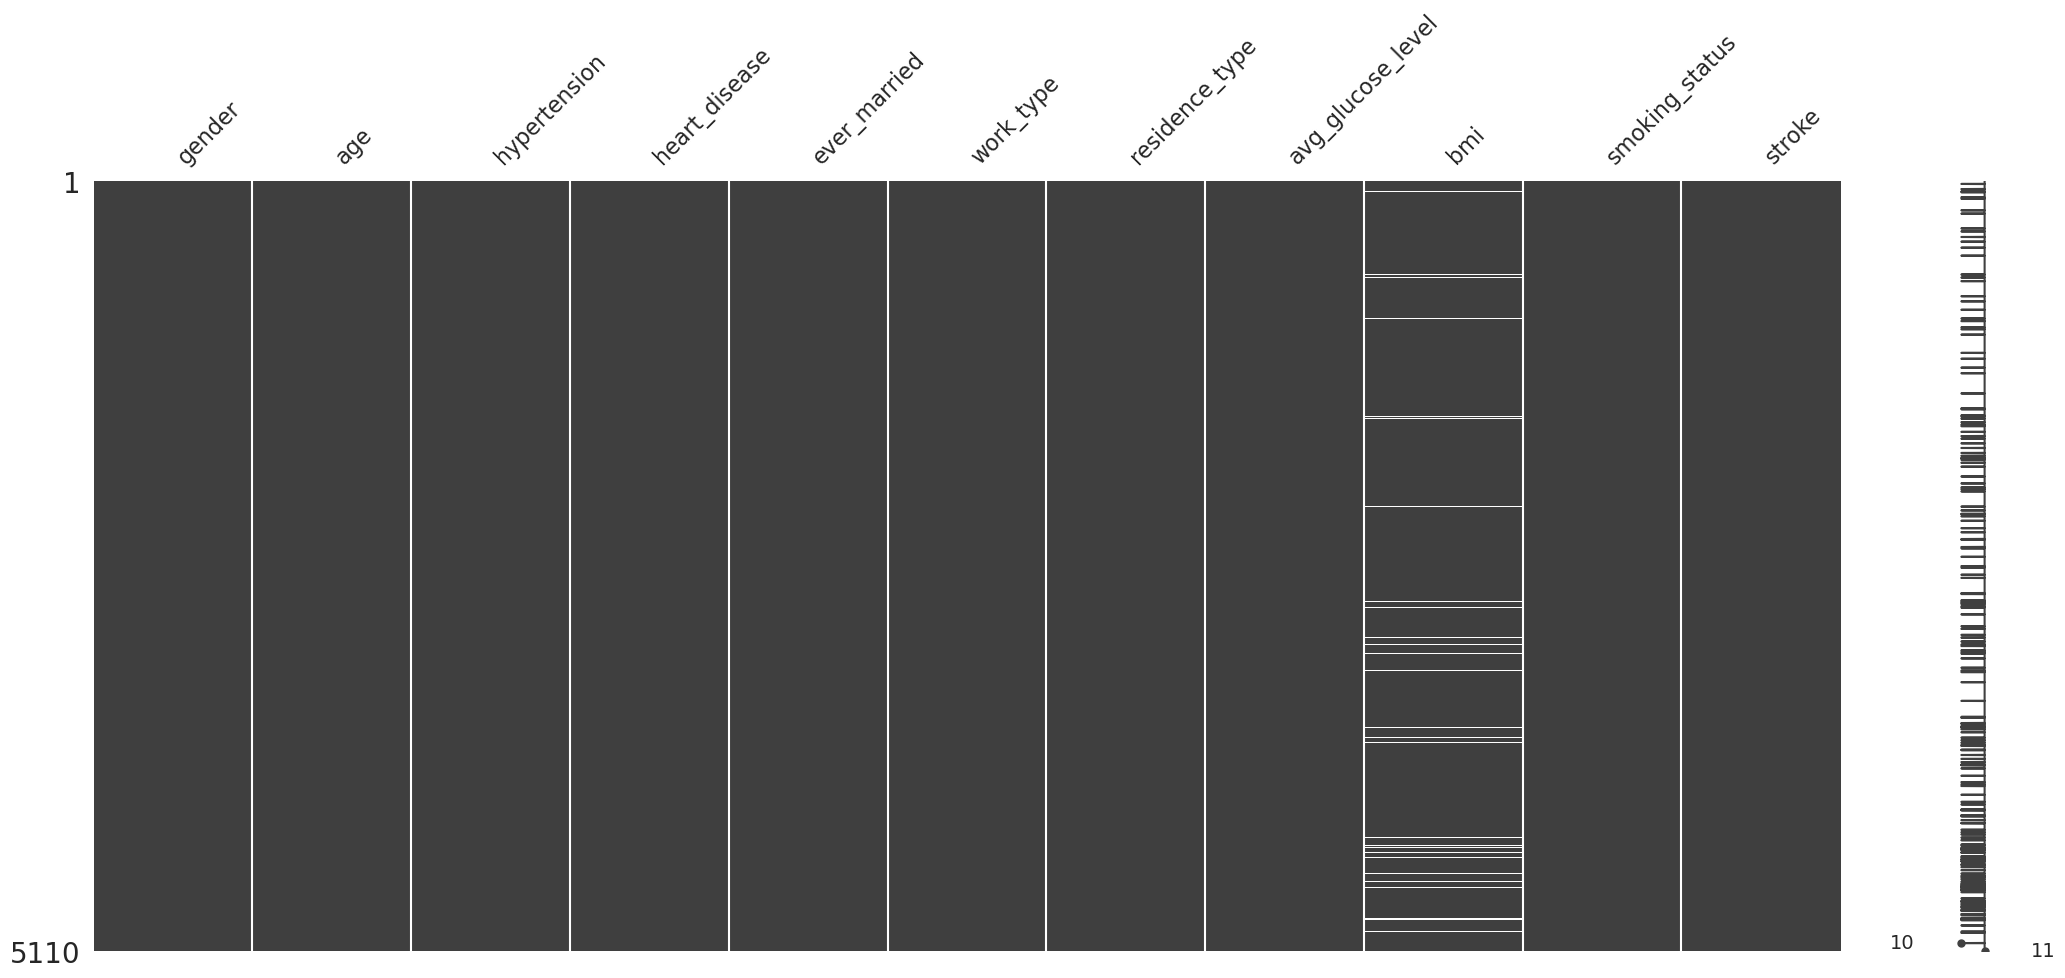

In [105]:
import missingno as msno
%matplotlib inline

df_sorted = df.sort_values(by=["age"])
msno.matrix(df_sorted)
plt.show()

The nullity plot shows that when the data is sorted by age, the missing BMI values seem to be concentrated towards the very young patients, and the elderly patients. Without further information, 

In order to determine how to deal with the missing values, let's see what percent of samples are missing a BMI measurement

In [106]:
print(f"{round(100 * df.isna().sum().sum() / len(df), 3)}% of samples are missing BMI")

3.933% of samples are missing BMI


With only about 4% of patients missing a BMI measurement, it is probably safe to impute the missing values, especially if a given imputation strategy can keep the distribution of the new data close to the original.

#### Smoking status

While there are no missing values for the smoking_status attribute, there is a significant number of patients (about one fifth of samples) whose smoking status is designated as "Unknown." The dataset source does not provide information on how this data was obtained, but the categories in this dataset are similar to ones found in the CDC's protocol for the National Health Interview Survey. The most recent status codes listed there specify one category "unknown if ever smoked." This may be a catch-all category for patients who were unwilling to share their smoking habits, or did not fit neatly into one of the other categories. For this analysis, I will keep patients with an unknown smoking status in the dataset, as patients with this status may still be of interest in other regards.

[2] https://www.cdc.gov/nchs/nhis/tobacco/tobacco_recodes.htm

#### Gender

There is one patient in the dataset whose gender is marked as "other." The dataset source unfortunately does not provide any more specific information on what this designation means. For most analyses, this will not be an issue. However, because there is only one such patient in the dataset, for any analysis using gender as a category, I have excluded this patient, as the lack of observations makes the "other" category not very helpful.

#### Duplicates

There are no duplicated values in the dataset.

In [107]:
print(f"There are {len(df[df.duplicated()])} duplicates in the dataset")

There are 0 duplicates in the dataset


#### Outliers

We have two numeric features in the dataset: BMI and average glucose level. A histogram with kernel density estimates is shown below for each feature

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64
count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64
count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64


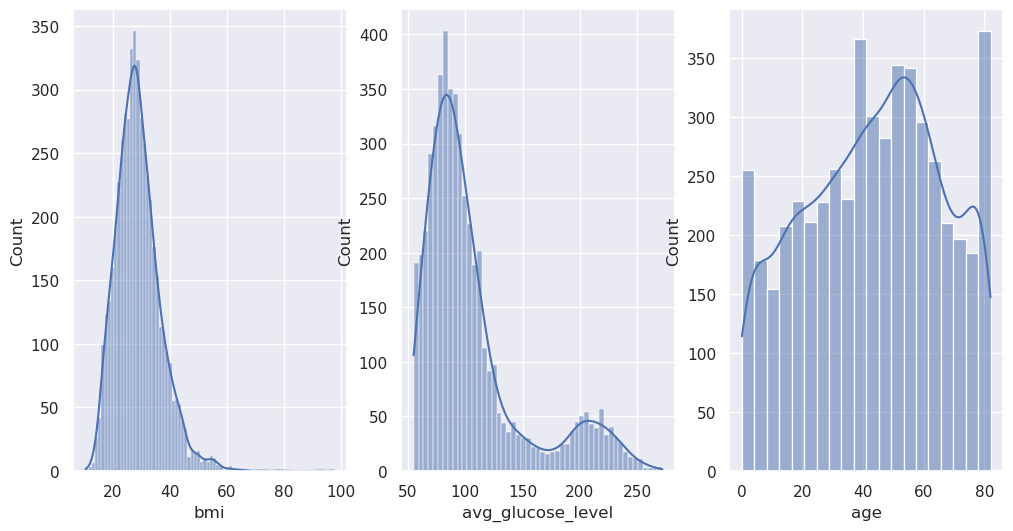

In [108]:
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
sns.histplot(df.bmi, kde=True)

plt.subplot(1,3,2)
sns.histplot(df.avg_glucose_level, kde=True)

plt.subplot(1,3,3)
sns.histplot(df.age, kde=True)

print(df.bmi.describe())
print(df.avg_glucose_level.describe())
print(df.age.describe())

For BMI, there are quite a few outliers lying far above the mean of about 28.8, with the highest being 97.6. The CDC designates a BMI of greater than 30 as obese, so these outliers are representative of extremely obese patients [2]. The CDC also states that obese individuals are at an elevated risk of experiencing a stroke [3]. Given this information, extreme obesity could be a very important piece of data for classification of risk, so these outliers will be kept in the dataset.

The average glucose level shows a bimodal distribution, with no signficant outliers from visual inspection.

[3] https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#obesity 

#### Class imbalance

In [109]:
print(f"{df.stroke.sum()} / {df.stroke.count()} patients experienced a stroke")

249 / 5110 patients experienced a stroke


Of the 5110 patients in the dataset, there are only 249 who experienced a stroke. This may be enough for now to analyze the dataset, but it could be a problem for a classification model in the future, which will have trouble learning how to predict a stroke from so few observations.

#### Imputation

Patients with a missing BMI measurement are still otherwise valid samples in the dataset. Eliminating them could get rid of valuable data and weaken the overall analysis. So these values will be imputed. I will compare three imputation strategies:
* Split-Impute-Combine (using median)
* KNN Imputation (k=5)
* Simple median imputation

In [110]:
#This code cell is adapted from the in-class demo notebook

groups = ["gender","hypertension","heart_disease","ever_married","work_type","residence_type","smoking_status","stroke"] #categorical features to group by

df_grouped = df.groupby(by=groups)
func = lambda grp: grp.fillna(grp.median()) # within groups, fill using median (define function to do this)

df_sic_imputed = df.copy()
df_sic_imputed["bmi"] = df_grouped["bmi"].transform(func)

# drop any rows that still had missing values after grouped imputation
df_sic_imputed.dropna(inplace=True)

df_sic_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5094 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5094 non-null   object 
 1   age                5094 non-null   float64
 2   hypertension       5094 non-null   int64  
 3   heart_disease      5094 non-null   int64  
 4   ever_married       5094 non-null   object 
 5   work_type          5094 non-null   object 
 6   residence_type     5094 non-null   object 
 7   avg_glucose_level  5094 non-null   float64
 8   bmi                5094 non-null   float64
 9   smoking_status     5094 non-null   object 
 10  stroke             5094 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 477.6+ KB


In [111]:
from sklearn.impute import SimpleImputer, KNNImputer

#Feature subset to use for imputation
features = ["hypertension", "heart_disease", "ever_married", "avg_glucose_level", "bmi", "stroke"]

#Convert ever_married to 0/1 values
df.ever_married.replace({"No": 0, "Yes": 1}, inplace=True)

#KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

df_knn_imputed = df.copy()
subset = df_knn_imputed[features]
df_knn_imputed[features] = knn_imputer.fit_transform(subset)

df_knn_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   float64
 3   heart_disease      5110 non-null   float64
 4   ever_married       5110 non-null   float64
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   float64
dtypes: float64(7), object(4)
memory usage: 439.3+ KB


In [112]:
#Simple median imputation
med_imputer = SimpleImputer(strategy="median")

df_med_imputed = df.copy()
subset = df_med_imputed[features]
df_med_imputed[features] = med_imputer.fit_transform(subset)

print(df_med_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   float64
 3   heart_disease      5110 non-null   float64
 4   ever_married       5110 non-null   float64
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   float64
dtypes: float64(7), object(4)
memory usage: 439.3+ KB
None


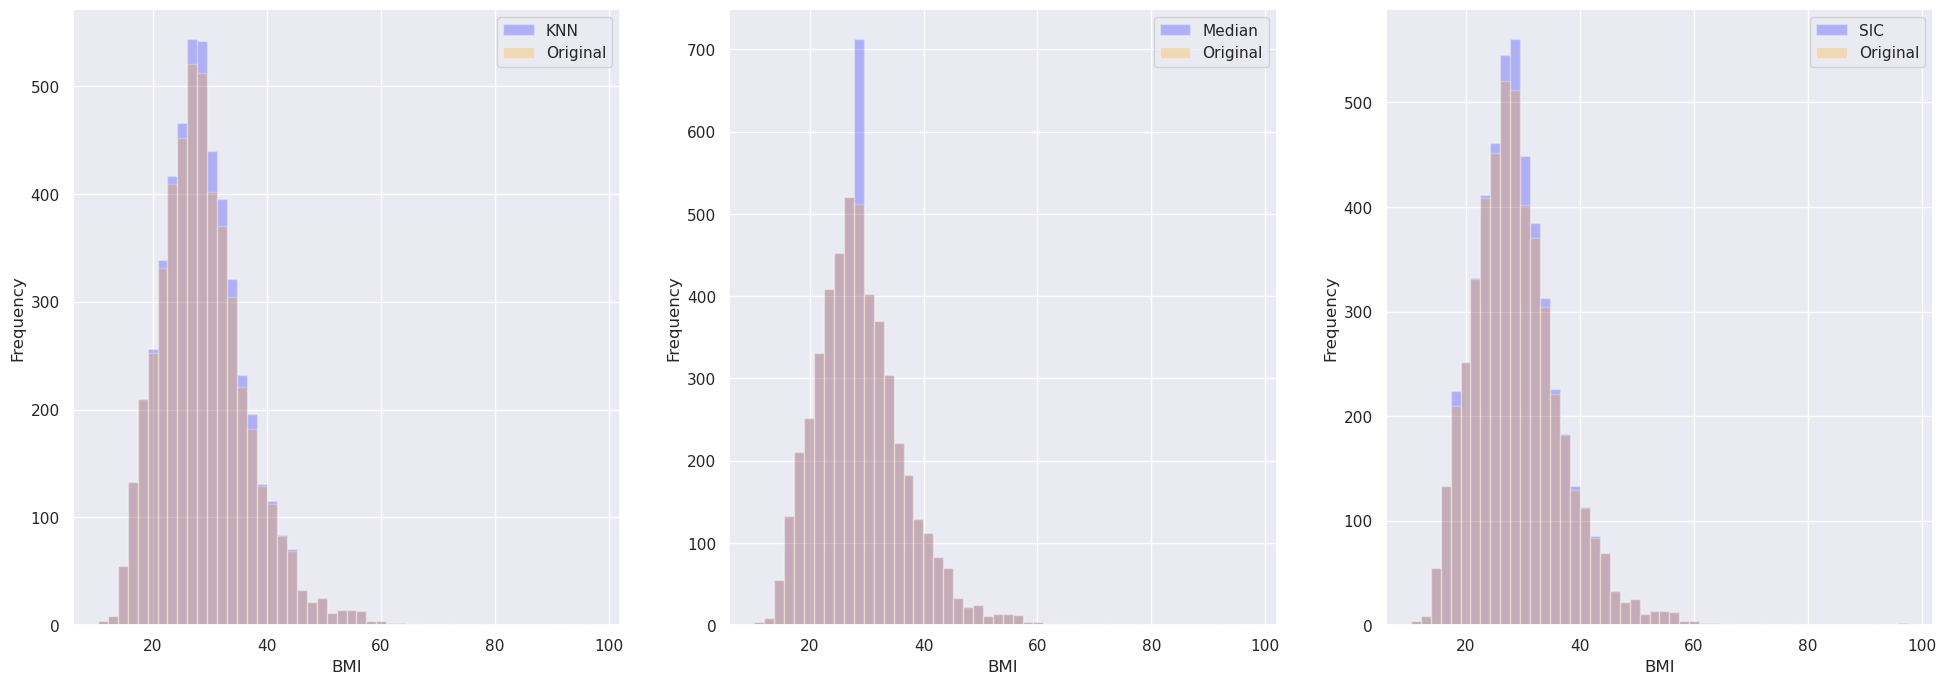

In [113]:
plt.figure(figsize=(24,8))

bin_ct = 50

plt.subplot(1, 3, 1)
df_knn_imputed.bmi.plot(kind="hist", alpha=0.25, color="blue", bins=bin_ct, label="KNN")
df.bmi.plot(kind="hist", alpha=0.25, color="orange", bins=bin_ct, label="Original")
plt.legend()
plt.xlabel("BMI")


plt.subplot(1, 3, 2)
df_med_imputed.bmi.plot(kind="hist", alpha=0.25, color="blue", bins=bin_ct, label="Median")
df.bmi.plot(kind="hist", alpha=0.25, color="orange", bins=bin_ct, label="Original")
plt.legend()
plt.xlabel("BMI")

plt.subplot(1, 3, 3)
df_sic_imputed.bmi.plot(kind="hist", alpha=0.25, color="blue", bins=bin_ct, label="SIC")
df.bmi.plot(kind="hist", alpha=0.25, color="orange", bins=bin_ct, label="Original")
plt.legend()
plt.xlabel("BMI")

plt.show()

The above histograms show the distribution of the imputed BMI column compared with the original BMI data. KNN and simple median imputation methods were able to fill all missing values, while SIC imputation was not. From a visual inspection, KNN imputation performs the best in terms of preserving the shape of the original BMI distribution. The split-impute-combine technique is decent as well, however, it should be considered that many BMI values were not able to be filled and were dropped from the dataset during SIC. Thus, KNN imputation is the best choice from these options, and the rest of this analysis will use the imputed dataset.

## 3. Data Visualization

### 3.1 Feature distributions

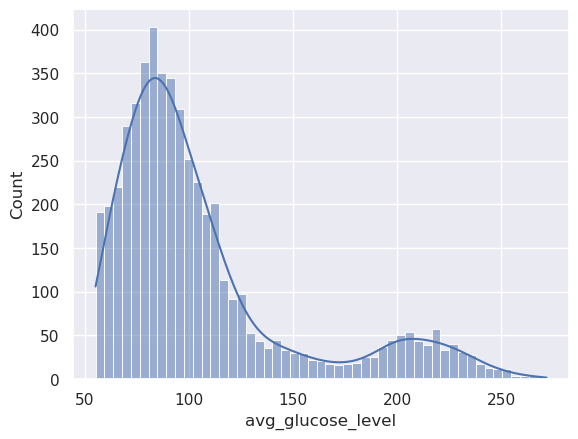

In [114]:
sns.histplot(df_knn_imputed.avg_glucose_level, kde=True)
plt.show()

The above histogram with kernel density estimate shows the distribution of average glucose levels in the dataset. The feature appears to be bimodal, with most patients falling near 80, and another small grouping near 220.

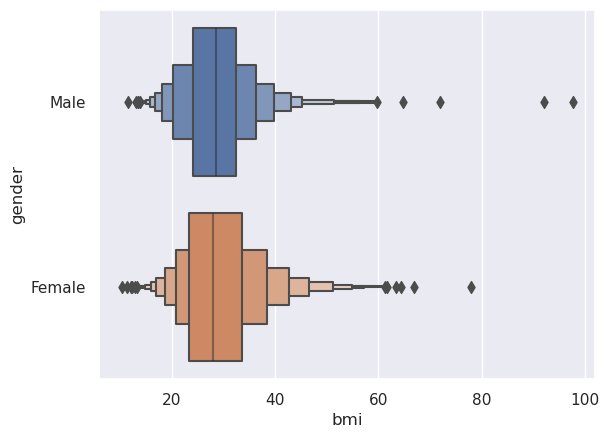

In [115]:
sns.boxenplot(data=df_knn_imputed[df_knn_imputed.gender != "Other"], x="bmi", y="gender") #excluding other category just for this plot
plt.show()

The above box plot shows the distribution of BMI, separated by gender. There is a large number of outliers for both men and women. Between men and women, the distribution is quite similar, though the highest outliers belong to the male category.

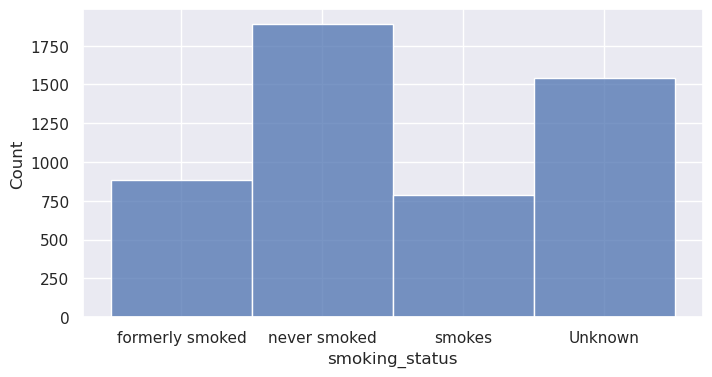

In [116]:
plt.figure(figsize=(8,4))
sns.histplot(df_knn_imputed.smoking_status)
plt.show()

This histogram shows the distribution for each smoking category. Unfortunately, the "unknown" category is the second largest, so without documenation from the dataset source, we may need to look at other data to gain some insight on what the unknown category might mean.

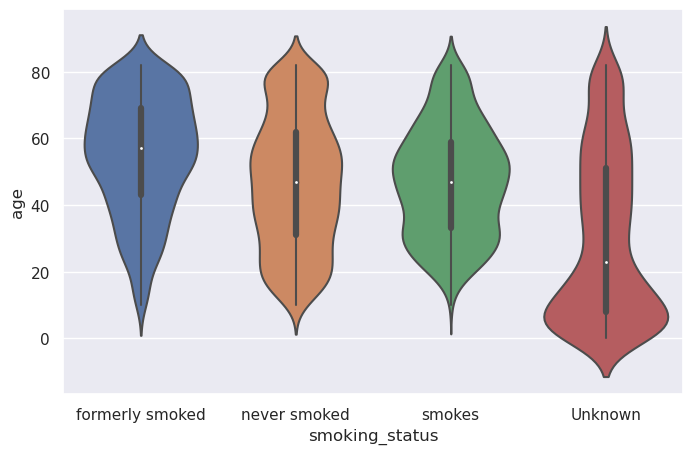

In [117]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df_knn_imputed, x="smoking_status", y="age")
plt.show()

This violin plot shows the smoking status relative to age on the y-axis. The plot shows that the unknown category is much more dense in the age 0-20 range, and is concentrated towards younger patients in general. Using information from the CDC's webpage on smoking status codes [2], it seems plausible that patients in the unknown category could be those who were not comfortable answering a questionnaire on their tobacco usage. It could make sense for the patients in this category to skew younger, as teenage smokers might not want to answer honestly about their smoking habits in a questionnaire.

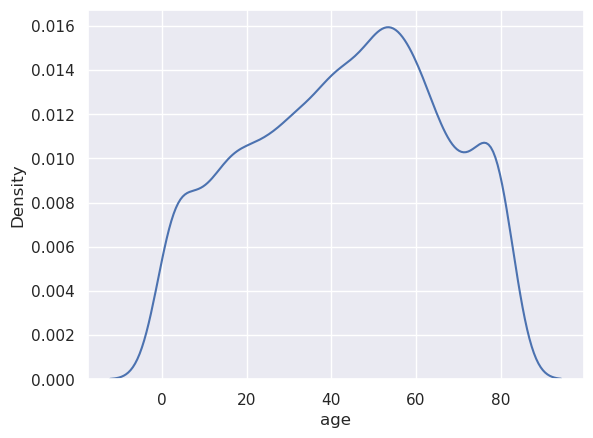

In [118]:
sns.kdeplot(data=df_knn_imputed, x="age")
plt.show()

This KDE plot shows the distribution of age. The distribution looks somewhat left-skewed, with the largest concentration of patients in the middle-aged range (about 50 years old). Another way to look at this feature that might be helpful is to discretize age into categories, and plot a categorical histogram.

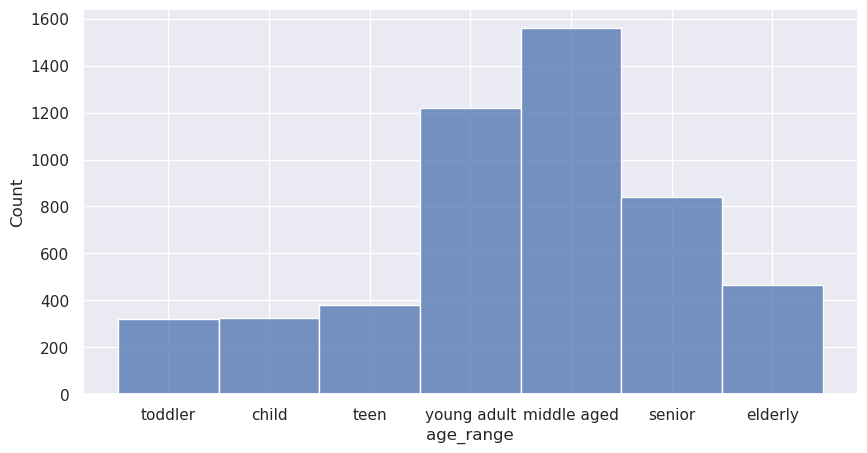

In [119]:
df_knn_imputed["age_range"] = pd.cut(df_knn_imputed.age, bins=[0,5,13,20,40,60,75,200],
                                    labels=["toddler","child","teen","young adult","middle aged","senior","elderly"])

plt.figure(figsize=(10,5))
sns.histplot(data=df_knn_imputed, x="age_range")
plt.show()

By this grouping, young adults and middle-aged patients are the two most common subsets in the dataset. Given that stroke risk increases with age according to the CDC (https://www.cdc.gov/stroke/facts.htm), this categorization could be of interest for exploring that trend in the dataset. Unfortunately though, the sample size is small for both younger patients (infants through teens) and older patients (seniors and the elderly). We should be more reserved in making broad generalizations about these categories due to the small sample size.

### 3.2 Questions and Insights

##### 3.2.1 How does BMI category affect risk of stroke relative to age?

Using the CDC's BMI categories [1], BMI can be discretized for patients over the age of 20 (categories have to be broken down by age and sex for individuals under 20), into the following categories:
* Underweight
* Healthy weight
* Overweight
* Obese

Given these categories, we can observe the risk of stroke, and how it scales with age in each category.

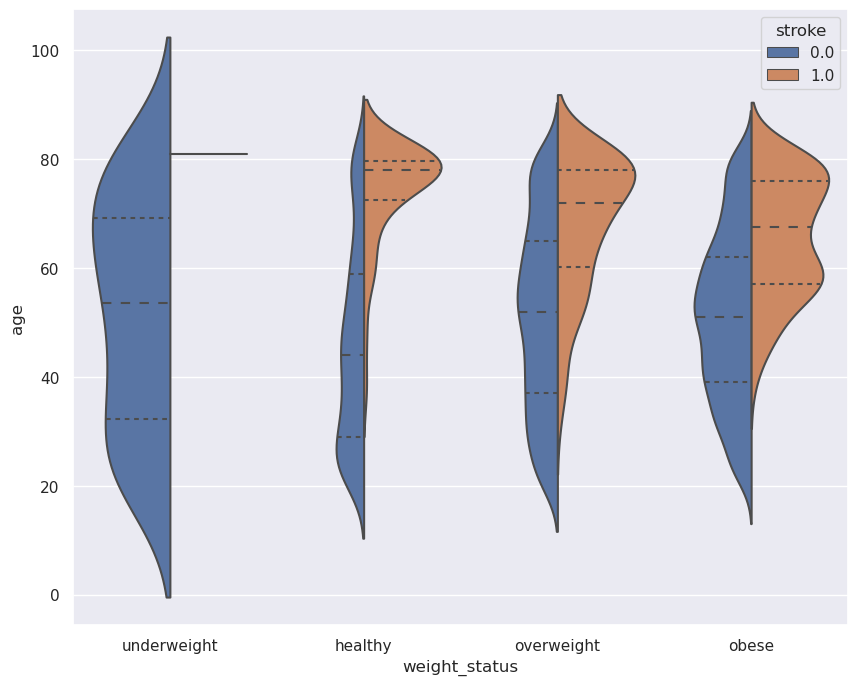

In [120]:
#Discretize BMI into weight_status column
df_bmi_cat = df_knn_imputed[df_knn_imputed.age >= 20].copy()
df_bmi_cat["weight_status"] = pd.cut(x=df_bmi_cat["bmi"],
                                    bins=[0,18.5,25,30,100],
                                    labels=["underweight","healthy","overweight","obese"])

#Plot violin
plt.figure(figsize=(10,8))
sns.violinplot(data=df_bmi_cat, x="weight_status", y="age", hue="stroke", split=True, inner="quartile")
plt.show()

Moving from healthier weights on the left, to unhealthier weights on the right, there is a clear increase in the number of patients who have experienced a stroke. In the underweight category, only one patient is recorded as having experienced a stroke. In the healthy category, strokes are concentrated in the elderly. For the overweight and obese categories, strokes occur more frequently, and in progressively younger patients. The main inference to draw from this graph is that being overweight or obese significantly increases the risk of stroke, while the risk grows with age in all weight categories.

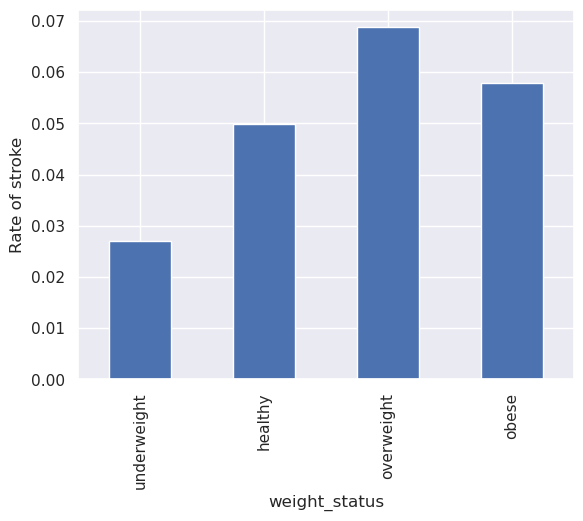

In [121]:
df_bmi_grp = df_bmi_cat.groupby(by="weight_status")

(df_bmi_grp.stroke.sum() / df_bmi_grp.stroke.count()).plot(kind="bar")
plt.ylabel("Rate of stroke")
plt.show()

This trend is further confirmed in the above histogram, which shows the percentage of each weight category that has experienced a stroke. Interestingly, the overweight category has a higher percentage than the obese category. Although the percentage is higher, the previous violin plot showed that people in the overweight category are more likely to experience a stroke later in life than the obese category.

##### 3.2.2 What effect does smoking have on risk of stroke?

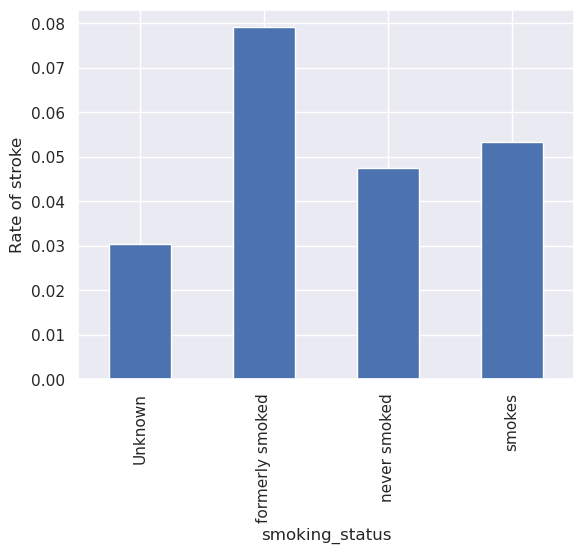

In [122]:
df_smoking_grp = df_knn_imputed.groupby(by="smoking_status")

(df_smoking_grp.stroke.sum() / df_smoking_grp.stroke.count()).plot(kind="bar")
plt.ylabel("Rate of stroke")
plt.show()

Interestingly, the "formerly smoked" category shows the highest rate of stroke, while the rate of stroke is relatively similar between the "never smoked" and "smoked" categories. Perhaps the former smokers are patients who were forced to quit due to health conditions, and would be a group more vulnerable to strokes. Also, given that former smokers are people who have smoked for some amount of time and then decided to quit, it might be that the former smokers category skews older. A visualization with age may help to clarify.

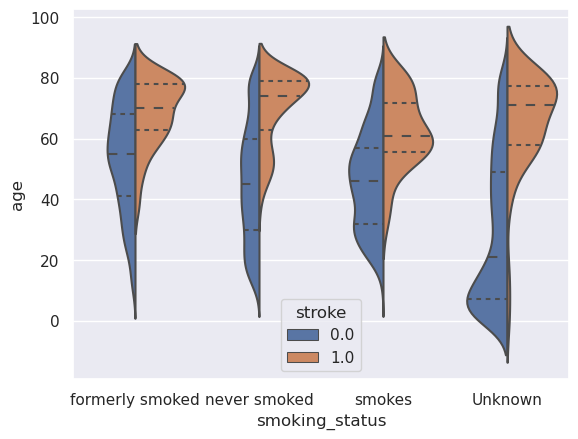

In [123]:
sns.violinplot(data=df_knn_imputed, x="smoking_status", y="age", hue="stroke", split=True, inner="quartile")
plt.show()

This is looking somewhat similar to the BMI categories violin plot, where the patients experiencing a stroke are more elderly people in all categories. It seems that the former smokers do indeed tend to be older patients based on the kernel density estimate for that category. Another interesting observation is that former smokers and current smokers show a similar trend of experiencing a stroke earlier in life than the non smoking category. Similar to a high BMI, it seems smoking is a risk that makes it more likely for a given patient to experience a stroke at a younger age than non smokers or lower BMI patients tend to.

#### 3.2.3 What age groups are at the highest risk of stroke?

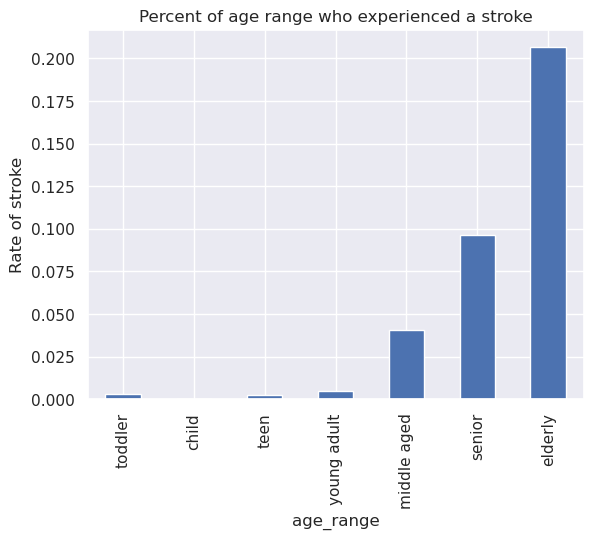

In [124]:
df_age_grp = df_knn_imputed.groupby(by="age_range")
(df_age_grp.stroke.sum() / df_age_grp.stroke.count()).plot(kind="bar")
plt.title("Percent of age range who experienced a stroke")
plt.ylabel("Rate of stroke")
plt.show()

df_knn_imputed.drop(columns=["age_range"], inplace=True) #get rid of age range column for now

This bar plot shows the rate of stroke for each age category, as the percent of each category which has experienced a stroke. The results are consistent with the information from the CDC stating that risk of stroke increases with age. In the younger age categories, toddler through young adult, the percentage of patients who experienced a stroke is quite low. In these categories, a stroke seems to be more of a freak occurrence. However, the middle-aged category shows a sharp increase in the rate of stroke. This trend continues to the elderly category, which is the most at-risk category in this dataset, with about 20% of all elderly patients experiencing a stroke.

<hr>

### 4. Dimensionality reduction using UMAP

Before starting on dimensionality reduction, all categorical features must be represented in a one hot encoding scheme

In [132]:
cat_features = ["gender","work_type","residence_type","smoking_status"]
features = ["bmi", "age", "avg_glucose_level", "hypertension", "heart_disease", "ever_married"]

ohe = pd.get_dummies(df_knn_imputed[cat_features])
df_umap = df_knn_imputed.copy()

df_umap.drop(columns=cat_features, inplace=True)
df_umap = pd.concat([ohe, df_umap], axis=1)

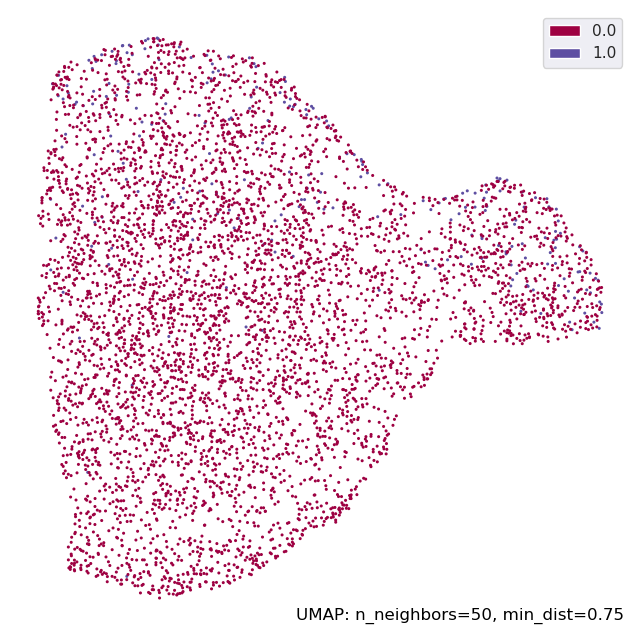

In [148]:
import umap
import umap.plot

mapper = umap.UMAP(n_neighbors=, min_dist=.75).fit(df_umap)
umap.plot.points(mapper, labels=df_knn_imputed.stroke)
plt.show()

In [ ]:
x=mapper.transform(df_knn_imputed[["age","avg_glucose_level","bmi"]])


(5110, 2)

<AxesSubplot:>

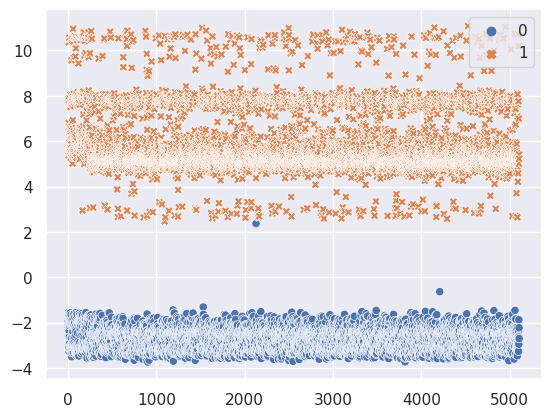

In [ ]:
sns.scatterplot(data=x)